In [340]:
import pandas as pd
import json
import collections
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import joblib
from functools import reduce

In [287]:
def accuracy(truth_json, predicted_path):
    
    predicted = pd.read_csv(predicted_path)
    correct = 0
    truth_dict = collections.Counter()
    
    with open(truth_json, 'r') as json_file:
        json_list = list(json_file)

    for i, json_str in enumerate(json_list):
        result = json.loads(json_str)
        truth_dict[result['label']] += 1
        if result['label'] == predicted['label'][i]:
            correct += 1
    print(correct, len(json_list))
    print(truth_dict.items())

    return


In [288]:
def json_to_csv(truth_json):
    dict = collections.defaultdict(list)
    with open(truth_json, 'r') as json_file:
        json_list = list(json_file)
    for i, json_str in enumerate(json_list):
        result = json.loads(json_str)
        dict['label'].append(result['label'])
        dict['id'].append(result['id'])
        dict['text'].append(result['text'])
    df = pd.DataFrame(data=dict)
    return df

def log_to_proba(file, res_file):
    df = pd.read_csv(file)
    df['proba'] = df['proba'].apply(lambda x: np.exp(x))
    
    df.to_csv(res_file, index=False)
    return df
        
        
    

In [311]:
log_to_proba("./uniter-oscar/vilio/Ensemble_files/U36_test_seen.csv", "./uniter-oscar/vilio/Ensemble_files/U36_test_seen_converted.csv")
log_to_proba("./uniter-oscar/vilio/data/O36/O36_test_unseen_SA.csv", "./uniter-oscar/vilio/Ensemble_files/O36_test_unseen_converted.csv")

,id,proba,label
0,42953,0.013462,0
1,23058,0.000307,0
2,13894,0.000350,0
3,37408,0.001043,0
4,82403,0.483420,0
...,...,...,...
995,54692,0.002246,0
996,1642,0.938795,1
997,46150,0.011260,0
998,19438,0.001328,0


In [61]:
test_ground_truth = json_to_csv('./vilio/data/test_unseen.jsonl')
test_ground_truth.to_csv('./vilio/Ensemble_files/test.csv')

In [210]:
accuracy("/home/jupyter/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/test.jsonl", "./vilbert/output/test.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/test.jsonl'

In [522]:
class Ensemble:
    def __init__(self, ground_truth, 
                 uniter, oscar, visual_bert, vilbert, 
                 ground_truth_train, uniter_train, visual_bert_train, vilbert_train,
                ground_truth_val, uniter_val, oscar_val, visual_bert_val, vilbert_val):
        self.ground_truth = self.jsonl_to_df(ground_truth)
        self.uniter = pd.read_csv(uniter)
        self.oscar = pd.read_csv(oscar)
        self.visual_bert = self.mmf_read_csv(visual_bert)
        self.vilbert = self.mmf_read_csv(vilbert)
        
        self.ground_truth_train = self.jsonl_to_df(ground_truth_train)
        self.uniter_train = self.log_to_proba(uniter_train)
        self.visual_bert_train = self.mmf_read_csv(visual_bert_train)
        self.vilbert_train = self.mmf_read_csv(vilbert_train)
        
        self.ground_truth_val = self.jsonl_to_df(ground_truth_val)
        self.uniter_val = self.log_to_proba(uniter_val)
        self.oscar_val = self.log_to_proba(oscar_val)
        self.visual_bert_val = self.mmf_read_csv(visual_bert_val)
        self.vilbert_val = self.mmf_read_csv(vilbert_val)
        
        self.combined = self.combine()
        self.combined_val = self.combine_val()
        self.create_dev()
        
    def create_dev(self):
        
        combined_dev = pd.merge(self.combined_val, self.ground_truth_val, on='id', left_index=False, right_index=False)
        combined_dev = combined_dev.sort_values(by=['label'])[:-125].sort_index()
        self.combined_dev = combined_dev[['id','proba_u','label_u','proba_x','label_x','proba_y','label_y','proba_z','label_z']]
        self.ground_truth_dev = combined_dev.drop(columns=['id','proba_u','label_u','proba_x','label_x','proba_y','label_y','proba_z','label_z'])
        
        
        
    def jsonl_to_df(self, jsonl_path):
        dict = collections.defaultdict(list)
        with open(jsonl_path, 'r') as json_file:
            json_list = list(json_file)
        for i, json_str in enumerate(json_list):
            result = json.loads(json_str)
            dict['label'].append(result['label'])
            dict['id'].append(result['id'])
            dict['text'].append(result['text'])
        df = pd.DataFrame(data=dict)
        return df
        
    def log_to_proba(self, file):
        df = pd.read_csv(file)
        df['proba'] = df['proba'].apply(lambda x: np.exp(x))
        return df
        
    def mmf_read_csv(self, path):
        
        df = pd.read_csv(path)
        df['proba'] = df['scores'].apply(lambda x: float(x[1:-1].split(", ")[1]))
        df = df.drop(columns=['scores'])
        df['label'] = df['proba'].apply(lambda x: 1 if x >= 0.5 else 0)
        return df
        
    
    def compare(self, predict, array=False, ground_truth_df = None):
        
        if type(ground_truth_df) == type(None):
            ground_truth_df = self.ground_truth
        
        correct = 0
        for i in predict.index:
            if predict['result'][i] == ground_truth_df['label'][i]:
                correct += 1
            
        #print(correct, '/', all, "Accuracy:", correct/all)
        return correct/len(predict)
    
    def compare_dev(self, predict, array=False):
        correct = 0
        all = len(predict)
        for i in range(all):
            if predict['result'][i] == self.ground_truth_dev['label'][i]:
                correct += 1
        #print(correct, '/', all, "Accuracy:", correct/all)
        return correct/all
    
    def combine(self):
        combine_a = pd.merge(self.uniter, self.oscar, on='id', suffixes=('_u', '_x'), left_index=False, right_index=False)
        combine_b = pd.merge(self.visual_bert, self.vilbert, on='id', suffixes=('_y', '_z'), left_index=False, right_index=False)
        combined = pd.merge(combine_a, combine_b, how='left', on='id')
        return combined
    
    def combine_val(self):
        combine_a = pd.merge(self.uniter_val, self.oscar_val, on='id', suffixes=('_u', '_x'), left_index=False, right_index=False)
        combine_b = pd.merge(self.visual_bert_val, self.vilbert_val, on='id', suffixes=('_y', '_z'), left_index=False, right_index=False)
        combined = pd.merge(combine_a, combine_b, how='left', on='id')
        return combined
        
    
    def simple_average(self, df, ground_truth_df=None):
        
        if type(ground_truth_df) == type(None):
            ground_truth_df = self.ground_truth
        
        cols = ['proba_u','proba_x','proba_y','proba_z']
        
        combined = df
        
        combined['avg'] = combined[cols].mean(axis=1)
        combined['result'] = combined['avg'].apply(lambda x: 1 if x >= 0.5 else 0)
        acc = self.compare(combined, ground_truth_df=ground_truth_df)
        print("Simple Average Accuracy:", acc)
        roc_auc = roc_auc_score(self.ground_truth['label'], combined['avg'])
        print('roc_auc:',round(roc_auc,4))
        
        return combined
        
    
    def single_model_acc(self):
        self.uniter['result'] = self.uniter['proba'].apply(lambda x: 1 if x >= 0.5 else 0)
        acc = self.compare(self.uniter)
        print("Uniter Accuracy :", acc)
        
        self.oscar['result'] = self.oscar['proba'].apply(lambda x: 1 if x >= 0.5 else 0)
        acc = self.compare(self.oscar)
        print("Oscar Accuracy :", acc)
        
        self.visual_bert['result'] = self.visual_bert['proba'].apply(lambda x: 1 if x >= 0.5 else 0)
        acc = self.compare(self.visual_bert)
        print("Visual BERT Accuracy :", acc)
        
        self.vilbert['result'] = self.vilbert['proba'].apply(lambda x: 1 if x >= 0.5 else 0)
        acc = self.compare(self.vilbert)
        print("VilBERT Accuracy :", acc)
        
        
    
    def weighted_average(self):
        combined = self.combined_dev
        max_acc = 0
        best_config = [0, 0, 0, 0]
        
        for i in range(0, 10):
            for j in range(0, 10):
                for k in range(0, 10):
                    for l in range(0, 10):
                        if i+j+k+l != 0:
                            combined['avg'] = (combined['proba_u']*i + combined['proba_x']*j + combined['proba_y']*k + combined['proba_z']*l)/(i+j+k+l)
                            combined['result'] = combined['avg'].apply(lambda x: 1 if x >= 0.5 else 0)
                            acc = self.compare(combined)
                            if acc > max_acc:
                                max_acc = acc
                                best_config = [i, j, k, l]
                                print(max_acc, best_config)
        combined_test = self.combined
        combined_test['avg'] = (combined_test['proba_u']*best_config[0] + combined_test['proba_x']*best_config[1] + combined_test['proba_y']*best_config[2] + combined_test['proba_z']*best_config[3])/sum(best_config)
        combined_test['result'] = combined_test['avg'].apply(lambda x: 1 if x >= 0.5 else 0)
        roc_auc = roc_auc_score(self.ground_truth['label'], combined_test['avg'])
        print('roc_auc:',round(roc_auc,4))
        acc = self.compare(combined_test)
        print("Performance on testset", acc)
        
        return max_acc, best_config
        
    
    def random_forest_train(self, n_estimators, min_samples_leaf, max_depth):
        
        combine_a = pd.merge(self.uniter_train, self.visual_bert_train, on='id', suffixes=('_u', '_y'), left_index=False, right_index=False)
        combined = pd.merge(combine_a, self.vilbert_train, on='id', left_index=False, right_index=False)
        self.X_train = combined[['proba_u','proba_y','proba']].replace(np.nan, 0)
        self.y_train = self.ground_truth_train['label']
        

        rf = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_depth=max_depth)
        rf.fit(self.X_train.to_numpy(), self.y_train.to_numpy())
        joblib.dump(rf, "./random_forest.joblib")
        #print("completed")
    
    def random_forest_predict(self, model):
        
        self.X_test = self.combined[['proba_u','proba_y','proba_z']].replace(np.nan, 0)
        self.y_test = self.ground_truth['label'].replace(np.nan, 0)
        
        loaded_rf = joblib.load(model)
        result = loaded_rf.predict(self.X_test.to_numpy())
        result = np.where(result<0.5, 0, 1)
        acc = np.mean(np.equal(result, self.y_test.to_numpy()))
        #print("Accuracy:", acc)
        roc_auc = roc_auc_score(self.ground_truth['label'], loaded_rf.predict_proba(self.X_test.to_numpy())[:,1])
        print('roc_auc:',round(roc_auc,4))
        return acc
    
    def random_forest_predict_val(self, model):
        self.X_val = self.combined_val[['proba_u','proba_y','proba_z']].replace(np.nan, 0)
        self.y_val = self.ground_truth_val['label'].replace(np.nan, 0)
        
        loaded_rf = joblib.load(model)
        result = loaded_rf.predict(self.X_val.to_numpy())
        result = np.where(result<0.5, 0, 1)
        acc = np.mean(np.equal(result, self.y_val.to_numpy()))
        
        #print("Accuracy:", acc)
        return acc
    
    

    def random_forest_predict_dev(self, model):
        self.X_dev = self.combined_dev[['proba_u','proba_y','proba_z']].replace(np.nan, 0)
        self.y_dev = self.ground_truth_dev['label'].replace(np.nan, 0)
        
        loaded_rf = joblib.load(model)
        result = loaded_rf.predict(self.X_dev.to_numpy())
        result = np.where(result<0.5, 0, 1)
        acc = np.mean(np.equal(result, self.y_dev.to_numpy()))
        #print("Accuracy:", acc)
        return acc

    
    def rf_search(self):
        
        max_acc = 0
        best_config = [0, 0, 0]
        
        for n_estimators in range(2, 22, 2):
            for min_samples_leaf in range(1, 11):
                for max_depth in range(1, 10):
                    self.random_forest_train(n_estimators, min_samples_leaf, max_depth)
                    acc = self.random_forest_predict_dev("./random_forest.joblib")
                    if acc > max_acc:
                        print("update acc ->", acc)
                        
                        max_acc = acc
                        best_config = [n_estimators, min_samples_leaf, max_depth]
                        print(best_config)
        
        return max_acc, best_config
                    
        
        # combined = self.simple_average()
        # X = combined['avg'].to_numpy()
        # X = X.reshape(-1, 1)
        # result = loaded_rf.predict(X)
        
        # correct = 0
        # all = len(result)
        # for i in range(all):
        #     if result[i] == self.ground_truth['label'][i]:
        #         correct += 1
        # print(correct, '/', all, "Accuracy:", correct/all)
        
        
        

In [523]:
ensemble = Ensemble("./test.jsonl",
                    "./uniter-oscar/vilio/Ensemble_files/U36_test_seen_converted.csv",
                    "./uniter-oscar/vilio/Ensemble_files/O36_test_unseen_converted.csv", 
                    "./vilbert/output/test.csv",
                    "./visual_bert/output/test.csv",
                    "./train.jsonl",
                    "./uniter-oscar/vilio/Ensemble_files/U36_train.csv",
                    "./vilbert/output/train.csv",
                    "./visual_bert/output/train.csv",
                    "./dev.jsonl",
                    "./uniter-oscar/vilio/Ensemble_files/U36_dev_seen.csv",
                    "./uniter-oscar/vilio/Ensemble_files/O36_dev_seen_SA.csv",
                    "./vilbert/output/dev.csv",
                    "./visual_bert/output/dev.csv"
                   )


In [530]:
ensemble.combined.iloc[1]

id         23058.000000
proba_u        0.000081
label_u        0.000000
proba_x        0.000307
label_x        0.000000
proba_y        0.000394
label_y        0.000000
proba_z        0.002611
label_z        0.000000
avg            0.000848
result         0.000000
Name: 1, dtype: float64

In [546]:
predict = list()
prob = list()
for i in range(len(ensemble.combined)):
    vote = 0
    for j in 'uxyz':
        vote += ensemble.combined.iloc[i][f'label_{j}']
    if vote > 2:
        predict.append(1)
    else:
        predict.append(0)
    prob.append(vote/4)

print('vote acc', np.mean(np.array(predict) == ensemble.ground_truth['label']))
print('vote roc_auc', roc_auc_score(ensemble.ground_truth['label'], np.array(prob)))

vote acc 0.819
vote roc_auc 0.8434202342141386


0.78

In [509]:
from sklearn.metrics import roc_auc_score

In [510]:
def show_roc_acc(df_combined, df_ground_truth, dataset):
    print(dataset,':')
    name2suffix = {"Uniter":"u", "Oscar":"x", "Visual BERT":"y", "VilBERT":"z"}

    for model, suffix in name2suffix.items():
        print(model)
        print('acc', round((df_combined[f'label_{suffix}'] == df_ground_truth['label']).value_counts()[1]/len(df_combined),4))
        print('roc_auc', round(roc_auc_score(df_ground_truth['label'], df_combined[f'label_{suffix}']),4))
        print()

In [511]:
show_roc_acc(ensemble.combined_dev, ensemble.ground_truth_dev, 'dev set')

dev set :
Uniter
acc 0.7333
roc_auc 0.688

Oscar
acc 0.7093
roc_auc 0.638

Visual BERT
acc 0.72
roc_auc 0.626

VilBERT
acc 0.6827
roc_auc 0.622



| Model      | acc | roc_auc     |
| :---        |    :----:   |          ---: |
| Uniter      | 0.7333       | 0.688   |
| Oscar   | 0.7093        |  0.638      |
| Visual BERT   | 0.72        | 0.626      |
| VilBERT   | 0.6827        | 0.622      |

In [512]:
show_roc_acc(ensemble.combined_val, ensemble.ground_truth_val, 'val set')

val set :
Uniter
acc 0.682
roc_auc 0.682

Oscar
acc 0.64
roc_auc 0.64

Visual BERT
acc 0.624
roc_auc 0.624

VilBERT
acc 0.632
roc_auc 0.632



| Model      | acc | roc_auc     |
| :---        |    :----:   |          ---: |
| Uniter      | 0.682       | 0.682   |
| Oscar   | 0.64        | 0.64      |
| Visual BERT   | 0.624        | 0.624      |
| VilBERT   | 0.632        | 0.632      |

In [433]:
show_roc_acc(ensemble.combined, ensemble.ground_truth, 'test set')

test set :
Uniter
acc 0.787
roc_auc 0.7895

Oscar
acc 0.81
roc_auc 0.8075

Visual BERT
acc 0.749
roc_auc 0.698

VilBERT
acc 0.751
roc_auc 0.7304



| Model      | acc | roc_auc     |
| :---        |    :----:   |          ---: |
| Uniter      | 0.787       | 0.7895   |
| Oscar   | 0.81        | 0.8075      |
| Visual BERT   | 0.749        | 0.698     |
| VilBERT   | 0.751       | 0.7304      |

In [434]:
ensemble.combined.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', length=1000)

In [524]:
ensemble.simple_average(ensemble.combined)

Simple Average Accuracy: 0.799
roc_auc: 0.8507


,id,proba_u,label_u,proba_x,label_x,proba_y,label_y,proba_z,label_z,avg,result
0,42953,0.000645,0,0.013462,0,0.004799,0,0.003127,0,0.005508,0
1,23058,0.000081,0,0.000307,0,0.000394,0,0.002611,0,0.000848,0
2,13894,0.000071,0,0.000350,0,0.004470,0,0.002874,0,0.001941,0
3,37408,0.000358,0,0.001043,0,0.000793,0,0.003317,0,0.001378,0
4,82403,0.997296,1,0.483420,0,0.329488,0,0.772131,1,0.645584,1
...,...,...,...,...,...,...,...,...,...,...,...
995,54692,0.000125,0,0.002246,0,0.002451,0,0.002677,0,0.001875,0
996,1642,0.999831,1,0.938795,1,0.998494,1,0.995843,1,0.983241,1
997,46150,0.000690,0,0.011260,0,0.009915,0,0.005577,0,0.006860,0
998,19438,0.000066,0,0.001328,0,0.000794,0,0.002854,0,0.001260,0


In [436]:
ensemble.single_model_acc()

Uniter Accuracy : 0.787
Oscar Accuracy : 0.831
Visual BERT Accuracy : 0.749
VilBERT Accuracy : 0.751


In [513]:
ensemble.random_forest_train(14, 8, 1)

In [514]:
ensemble.random_forest_predict("./random_forest.joblib",)

roc_auc: 0.8071


0.777

In [460]:
ensemble.rf_search()

update acc -> 0.6906666666666667
[2, 1, 1]
update acc -> 0.7253333333333334
[2, 1, 2]
update acc -> 0.728
[2, 2, 3]
update acc -> 0.7306666666666667
[2, 2, 5]
update acc -> 0.7333333333333333
[2, 3, 2]
update acc -> 0.752
[8, 1, 1]
update acc -> 0.7546666666666667
[18, 7, 1]


(0.7546666666666667, [18, 7, 1])

In [516]:
ensemble.random_forest_train(18, 7, 1)

In [518]:
ensemble.random_forest_predict('random_forest.joblib')

roc_auc: 0.8127


0.776

In [371]:
ensemble.simple_average()

Simple Average Accuracy: 0.799


,id,proba_u,label_u,proba_x,label_x,proba_y,label_y,proba_z,label_z,avg,result
0,42953,0.000645,0,0.013462,0,0.004799,0,0.003127,0,0.005508,0
1,23058,0.000081,0,0.000307,0,0.000394,0,0.002611,0,0.000848,0
2,13894,0.000071,0,0.000350,0,0.004470,0,0.002874,0,0.001941,0
3,37408,0.000358,0,0.001043,0,0.000793,0,0.003317,0,0.001378,0
4,82403,0.997296,1,0.483420,0,0.329488,0,0.772131,1,0.645584,1
...,...,...,...,...,...,...,...,...,...,...,...
995,54692,0.000125,0,0.002246,0,0.002451,0,0.002677,0,0.001875,0
996,1642,0.999831,1,0.938795,1,0.998494,1,0.995843,1,0.983241,1
997,46150,0.000690,0,0.011260,0,0.009915,0,0.005577,0,0.006860,0
998,19438,0.000066,0,0.001328,0,0.000794,0,0.002854,0,0.001260,0


In [521]:
ensemble.weighted_average()

0.608 [0, 0, 0, 1]
0.6293333333333333 [0, 0, 1, 0]
0.632 [0, 0, 6, 5]
0.64 [0, 0, 8, 7]
0.656 [0, 1, 0, 0]
0.6613333333333333 [0, 2, 1, 1]
0.664 [0, 5, 3, 1]
roc_auc: 0.8574
Performance on testset 0.825


(0.664, [0, 5, 3, 1])

In [29]:

def mmf_acc(df, dataset):
    
    dev_label = dict()

    acc_count = 0
    total_count = 0

    with open(f'/home/jupyter/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/{dataset}.jsonl', 'r') as f:
        for line in f:
            total_count += 1

            data = json.loads(line)
            [imid, url, label, text] = data['id'], data['img'], data['label'], data['text']
            dev_label[imid] = label

            if df.loc[df['id'] == int(imid)]['label'].item() == int(label):
                acc_count += 1

    print(acc_count, total_count, acc_count/total_count)

In [30]:
mmf_acc(ensemble.visual_bert, 'test')

749 1000 0.749


In [31]:
mmf_acc(ensemble.vilbert, 'test')

751 1000 0.751


0    250
1    200
Name: label, dtype: int64

In [230]:
4698/7500

0.6264

In [236]:
0.752

0.752

In [266]:
125/500

0.25

In [549]:
from mmf.common.registry import registry

model_cls = registry.get_model_class("vilbert")
model = model_cls.from_pretrained("vilbert/save")

/opt/conda/lib/python3.7/site-packages/omegaconf/resolvers/__init__.py:13: UserWarning: The `env` resolver is deprecated, see https://github.com/omry/omegaconf/issues/573
  "The `env` resolver is deprecated, see https://github.com/omry/omegaconf/issues/573"
/opt/conda/lib/python3.7/site-packages/omegaconf/grammar_visitor.py:257: UserWarning: In the sequence `MMF_LOG_DIR,` some elements are missing: please replace them with empty quoted strings. See https://github.com/omry/omegaconf/issues/572 for details.
  category=UserWarning,
/opt/conda/lib/python3.7/site-packages/omegaconf/grammar_visitor.py:257: UserWarning: In the sequence `MMF_REPORT_DIR,` some elements are missing: please replace them with empty quoted strings. See https://github.com/omry/omegaconf/issues/572 for details.
  category=UserWarning,
/opt/conda/lib/python3.7/site-packages/omegaconf/grammar_visitor.py:257: UserWarning: In the sequence `MMF_TENSORBOARD_LOGDIR,` some elements are missing: please replace them with empty

In [570]:
def demo_infer(path, text):
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.figure(figsize=(40,30))
    plt.show()
    
    return model.classify(path, text)
    

    

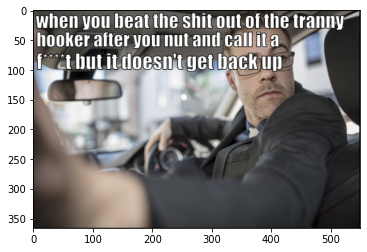

{'label': 1, 'confidence': 0.9988943934440613}

In [564]:
demo_infer('../data/img/20619.png',"when you beat the shit out of the tranny hooker after you nut and call it a but it f****t doesn't get back up")

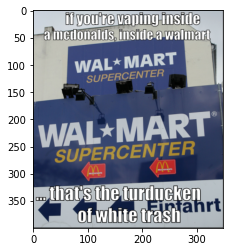

<Figure size 2880x2160 with 0 Axes>

{'label': 1, 'confidence': 0.9987013339996338}

In [572]:
demo_infer('../data/img/52097.png',"if you're vaping inside a mcdonalds, inside a walmart ... that's the turducken of white trash")

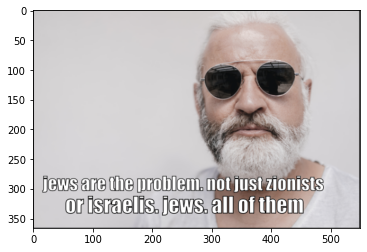

<Figure size 2880x2160 with 0 Axes>

{'label': 1, 'confidence': 0.9952991008758545}

In [574]:
demo_infer('../data/img/34508.png',"jews are the problem. not just zionists or sraelis. jews. all of them")

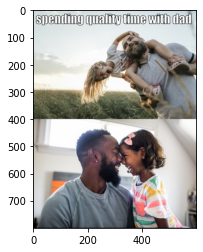

<Figure size 2880x2160 with 0 Axes>

{'label': 0, 'confidence': 0.9135643243789673}

In [577]:
demo_infer('../data/img/05384.png',"spending quality time with dad")

| Model      | acc | roc_auc     |
| :---        |    :----:   |          ---: |
| Uniter      | 0.787       | 0.7895   |
| Oscar   | 0.81        | 0.8075      |
| Visual BERT   | 0.749        | 0.698     |
| VilBERT   | 0.751       | 0.7304      |

| Ensemble      | acc | roc_auc     |
| :---        |    :----:   |          ---: |
| Vote      | 0.819       | 0.8434  |
| Simple Average  |    0.799    |   0.8507   |
| Weighted Average  |   0.825     | 0.8574  |
| Random Forest - Oscar  |    0.776   | 0.8127      |